In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, shutil, time, os.path as osp, logging, numpy as np
import torch
import matplotlib.pyplot as plt, cycler
import matplotlib
from tqdm.notebook import tqdm

HGCAL_LDRD_PATH = '../src' # Assuming cwd = hgcal_ldrd/notebooks
PVCNN_PATH = '../../pvcnn'
OUTPUT_PATH = osp.join(HGCAL_LDRD_PATH, '../output')

sys.path.append(HGCAL_LDRD_PATH)
from datasets.hitgraphs import HitGraphDataset
# Make sure datasets import is from hgcal_ldrd
# Then add pvcnn to the path
sys.path.append(PVCNN_PATH)

In [14]:
sys.path.append(osp.join(HGCAL_LDRD_PATH, '../scripts'))
pvcnnscript = __import__("pvcnn-script")

script = pvcnnscript.TrainingScript(debug=False)
# script.load_checkpoint = '/home/klijnsma/pvcnnhgcal/v0/output/checkpoints/model_checkpoint_PVConvForHGCAL_2562244_9c8b11eb88_klijnsma.best.pth.tar'
script.load_checkpoint = '/home/klijnsma/pvcnnhgcal/deploytest/hgcal_ldrd/output/checkpoints/model_checkpoint_PVConvForHGCAL_2562244_9c8b11eb88_klijnsma_004.pth.tar'
trainer = script.get_trainer()

    INFO:2020-06-01 18:15:50:pvcnn-script:95 Using dataset_path /home/klijnsma/pvcnnhgcal/deploytest/hgcal_ldrd/scripts/../../data/single-tau
    INFO:2020-06-01 18:15:50:pvcnn-script:110 10000, [ 8000  8000 10000]
    INFO:2020-06-01 18:15:50:pvcnn-script:152 using device cuda
    INFO:2020-06-01 18:15:50:base:31 Model: 
PVConvForHGCAL(
  (point_features): ModuleList(
    (0): PVConv(
      (voxelization): Voxelization(resolution=32, normalized eps = 0)
      (voxel_layers): Sequential(
        (0): Conv3d(5, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (point_features)

In [15]:
from torch_geometric.data import DataLoader
full_dataset, train_dataset, valid_dataset = script.get_full_dataset()
# Use just a few events for testing
# valid_dataset = torch.utils.data.Subset(valid_dataset, list(range(3)))
valid_loader = DataLoader(valid_dataset, batch_size=script.valid_batch_size, shuffle=False)

In [16]:
class Event():
    @classmethod
    def from_batch(cls, data, batch_output):
        if data.x.is_cuda:
            X = data.x.cpu().numpy()
            target = data.y_nodes.cpu().numpy()
        else:
            X = data.x.numpy()
            target = data.y_nodes.numpy()
        return cls(
            X = X, target = target,
            output_probabilities = batch_output.cpu().numpy()
            )
    
    def __init__(self, X, target, output_probabilities):
        self.X = X
        self.target = target
        self.output_probabilities = output_probabilities
        self.output = np.argmax(self.output_probabilities, axis=1)
        self.num_classes = self.output_probabilities.shape[1]
        self.num_hits = self.X.shape[0]
        
class EventFactory():
    def __init__(self, loader, max_events=None):
        self.loader = loader
        self.max_events = max_events
        self.do_tqdm = True
        
    def __iter__(self):
        with torch.no_grad():
            if self.do_tqdm:
                total = len(self.loader.dataset)
                if not(self.max_events is None) and self.max_events < total:
                    total = self.max_events
                iterator = tqdm(enumerate(self.loader), total=total)
            else:
                iterator = enumerate(self.loader)
            
            for i, data in iterator:
                if not(self.max_events is None) and i >= self.max_events: break
                batch_input = data.to(trainer.device)
                batch_target = data.y_nodes.type(torch.LongTensor).to(trainer.device)
                batch_output = trainer.model(batch_input)
                yield Event.from_batch(data, batch_output)                

In [17]:
class PlotEventDisplay():
    def __init__(self, event):
        self.event = event

    def plot_output(self, output, title=None, savefig=None):
        fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))        
        fig.set_facecolor('white')
        if title: fig.suptitle(title, fontsize=28)
        
        e_max = np.max(self.event.X[:,4])
        e_normed = 100.*np.tanh(self.event.X[:,4]/e_max)
        
        color_cycler = cycler.cycler(color=['b', 'r', 'g', 'y', 'm', 'c'])()
        
        for i_cat in range(self.event.num_classes):
            color = next(color_cycler)['color']
            X = self.event.X[output == i_cat]
            ax0.scatter(X[:,0], X[:,2], s=(e_normed), c=color)
            ax1.scatter(X[:,1], X[:,2], s=(e_normed), c=color)

        ax0.legend(['Noise', 'HAD', 'EM', 'MIP'], prop={'size': 24})
        fontsize = 24
        ax0.set_xlabel('x [cm]', fontsize=fontsize)
        ax0.set_ylabel('layer', fontsize=fontsize)
        ax1.set_xlabel('y [cm]', fontsize=fontsize)
        ax1.set_ylabel('layer', fontsize=fontsize)
        ax0.tick_params(axis='both', which='major', labelsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=20)
        if savefig:
            fig.savefig(savefig)
            plt.close(fig)

    def plot_prediction(self, savefig=None):
        return self.plot_output(self.event.output, 'Prediction', savefig)
    
    def plot_truth(self, savefig=None):
        return self.plot_output(self.event.target, 'Truth', savefig)

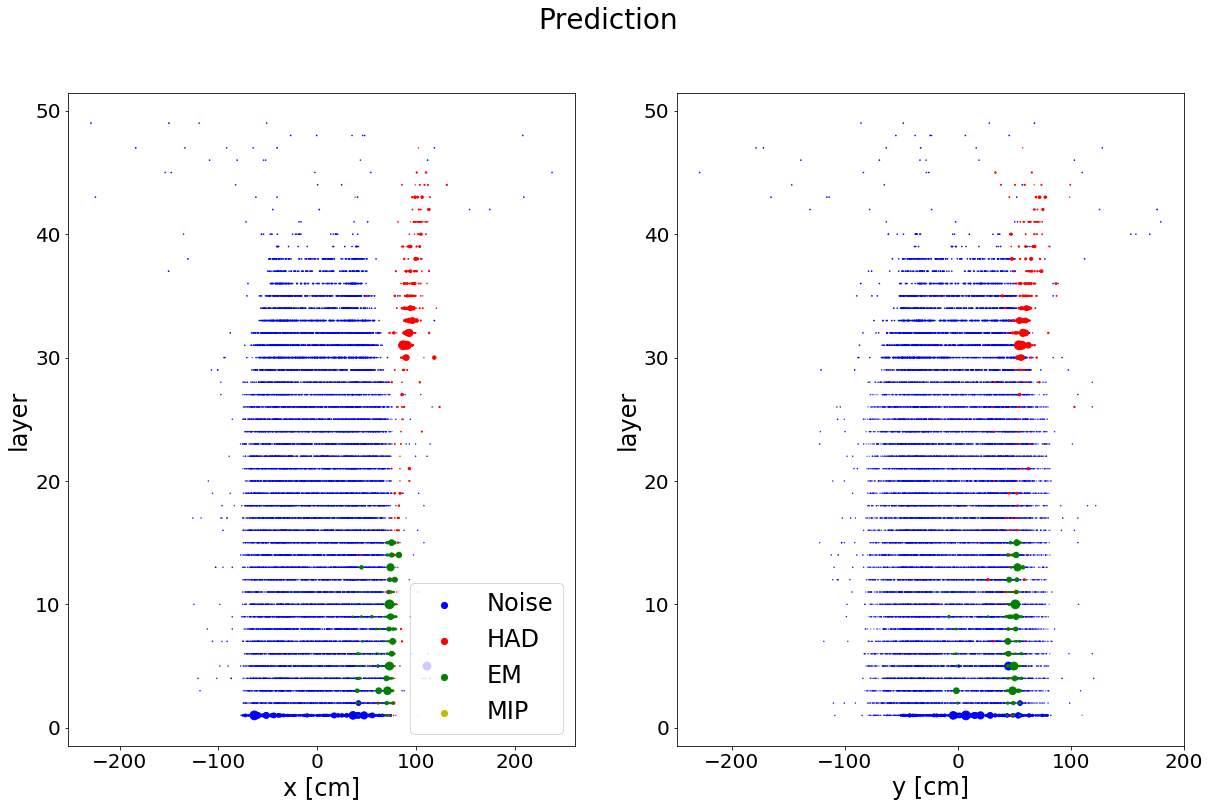

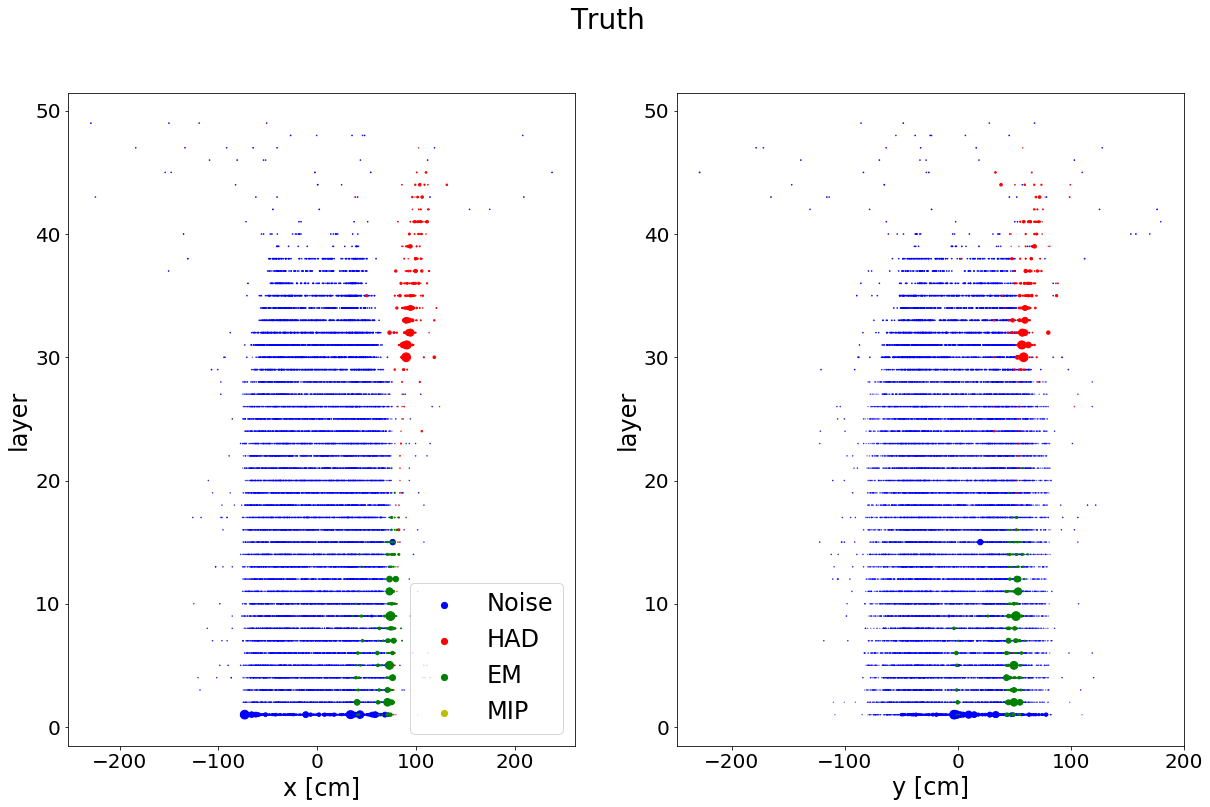

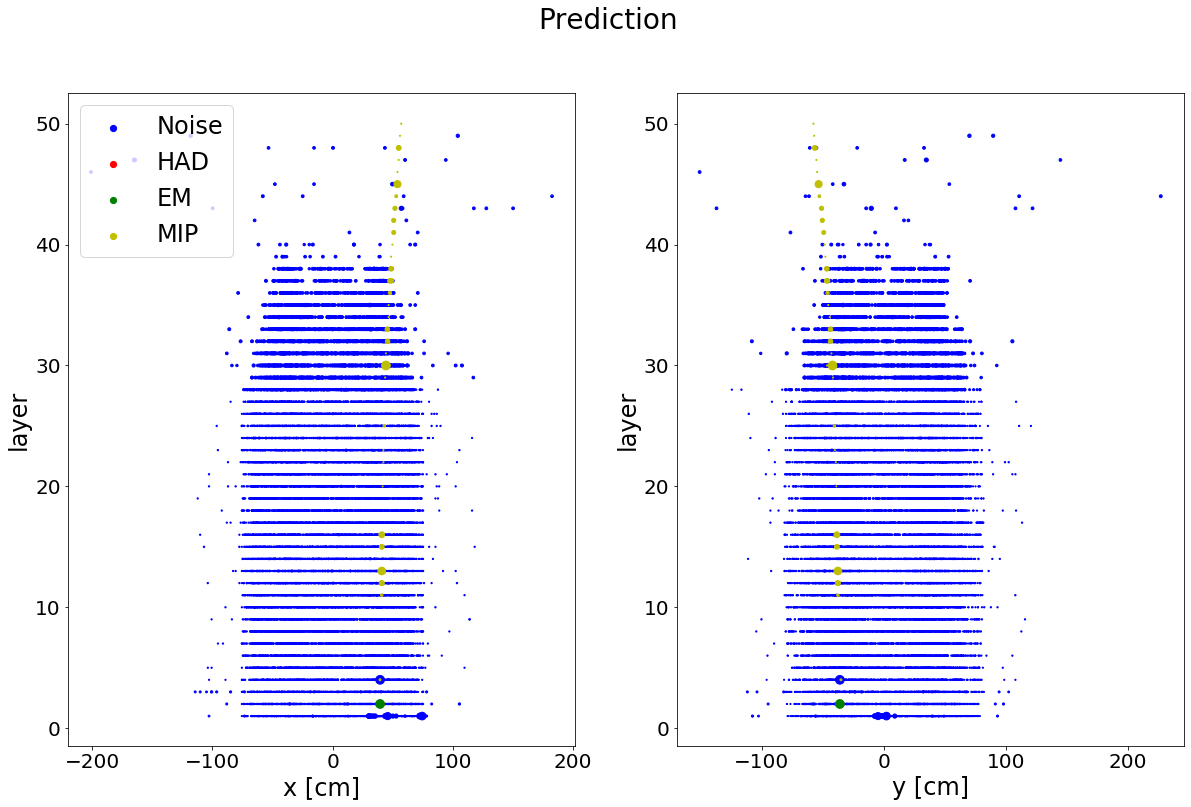

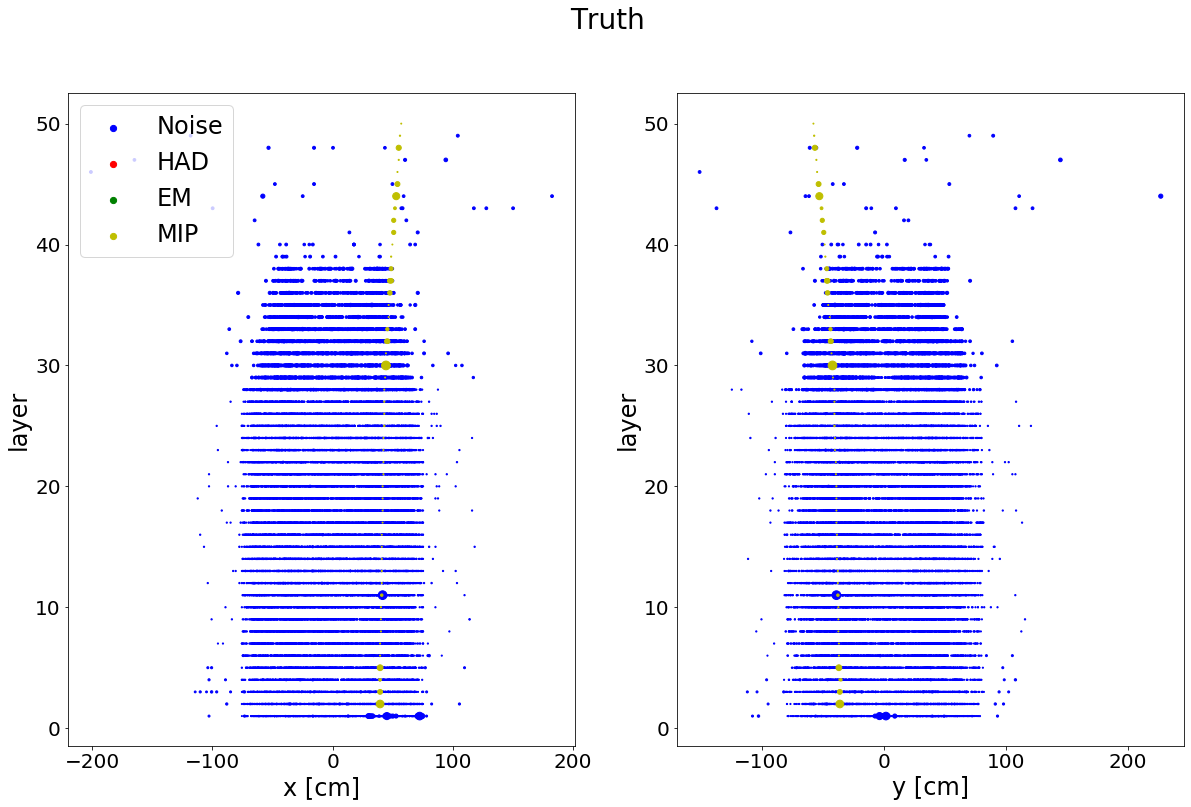

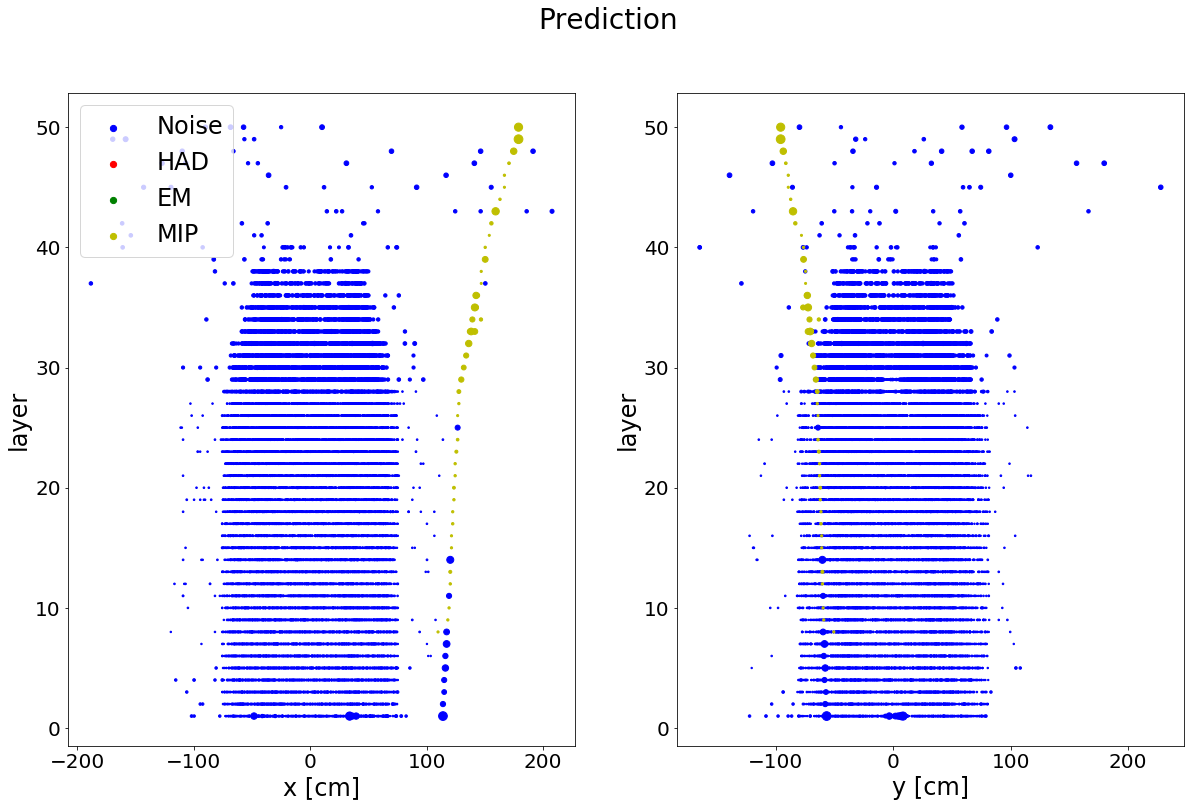

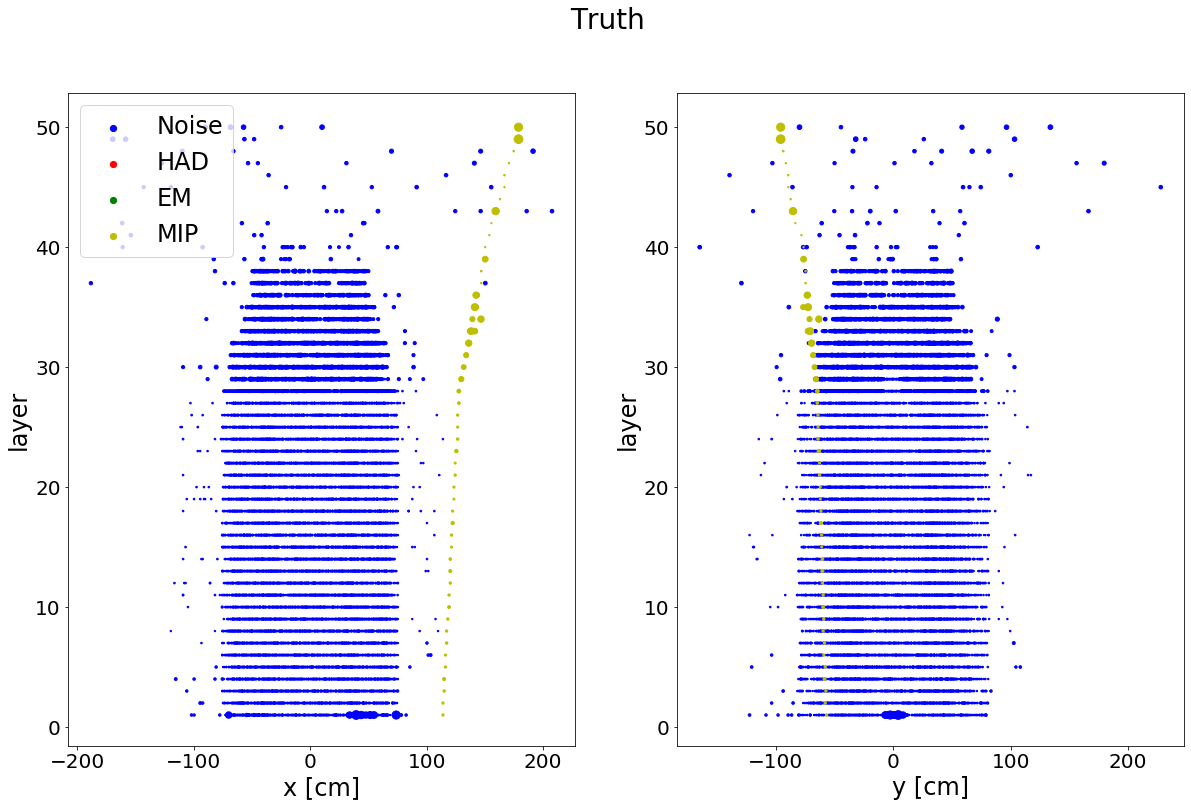

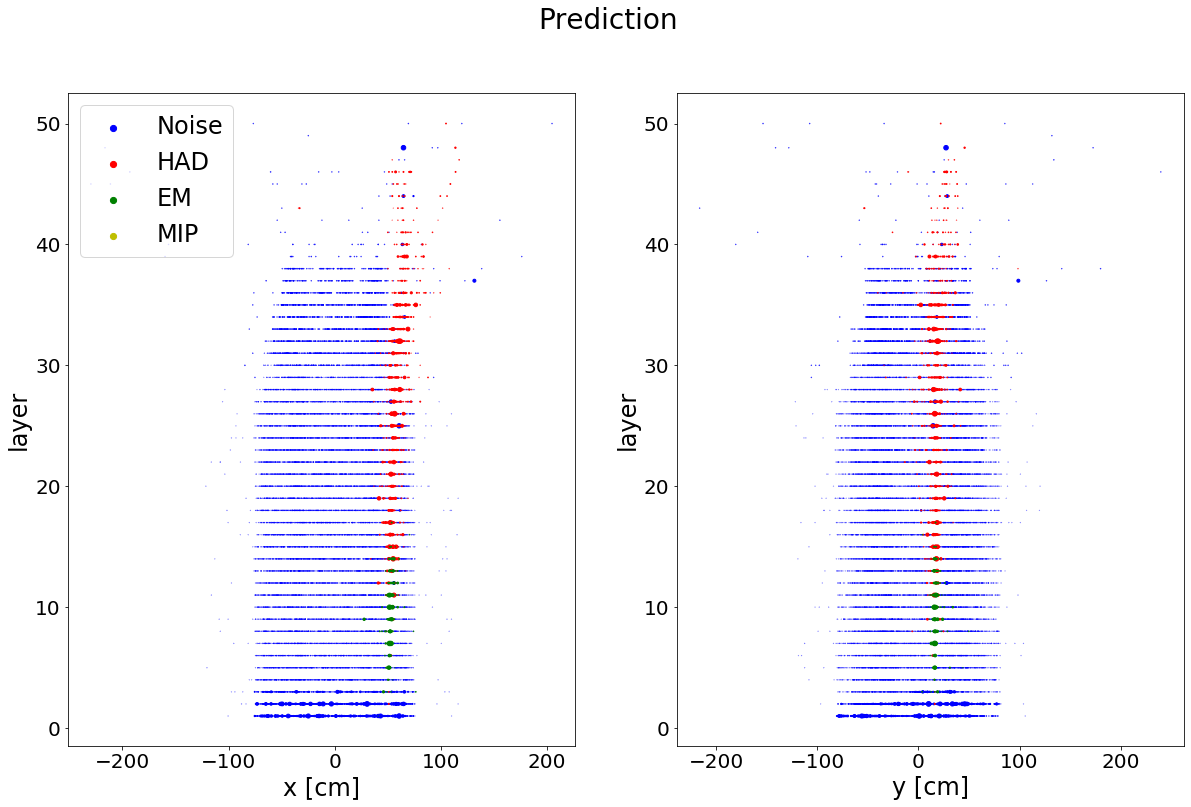

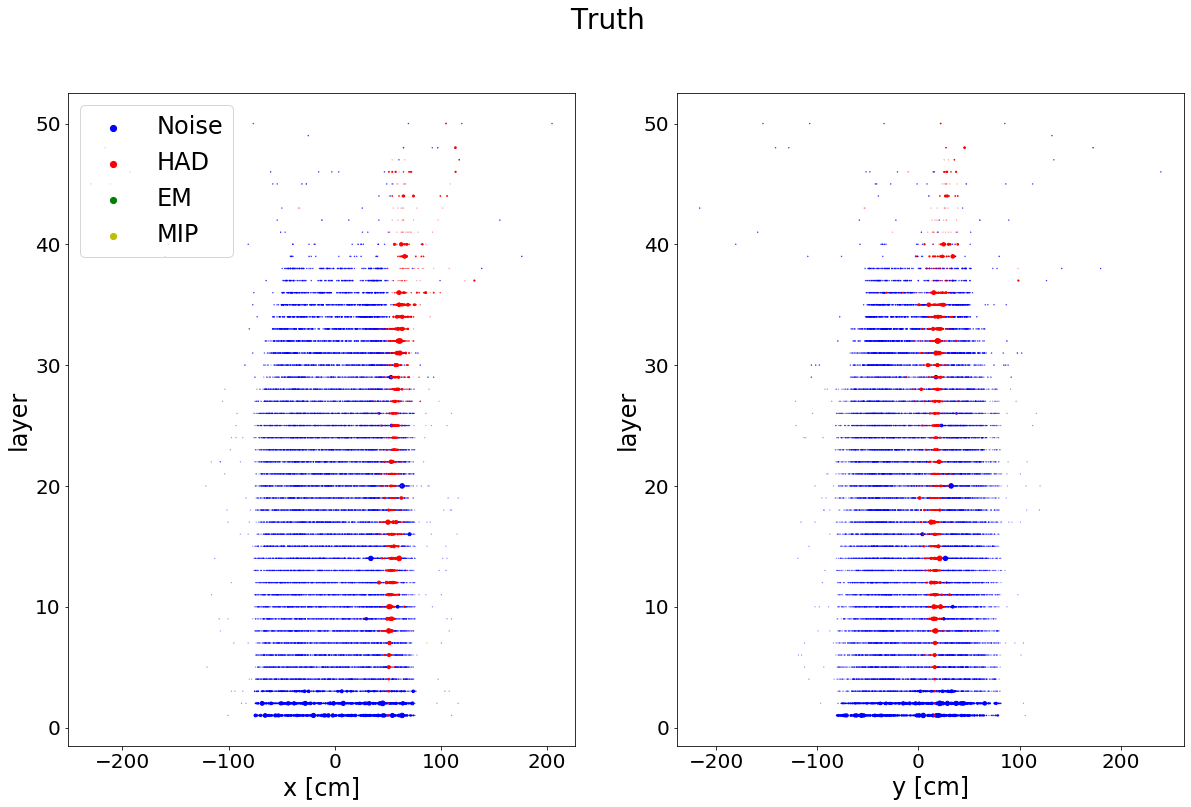

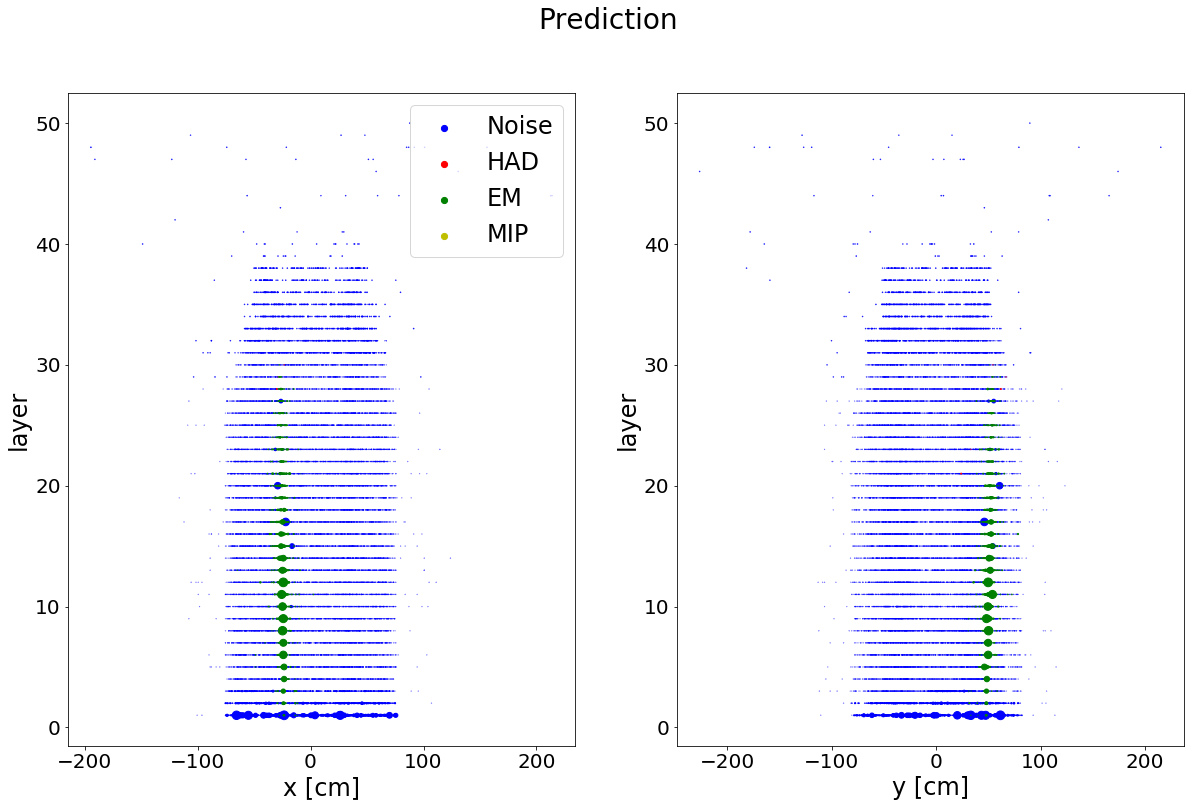

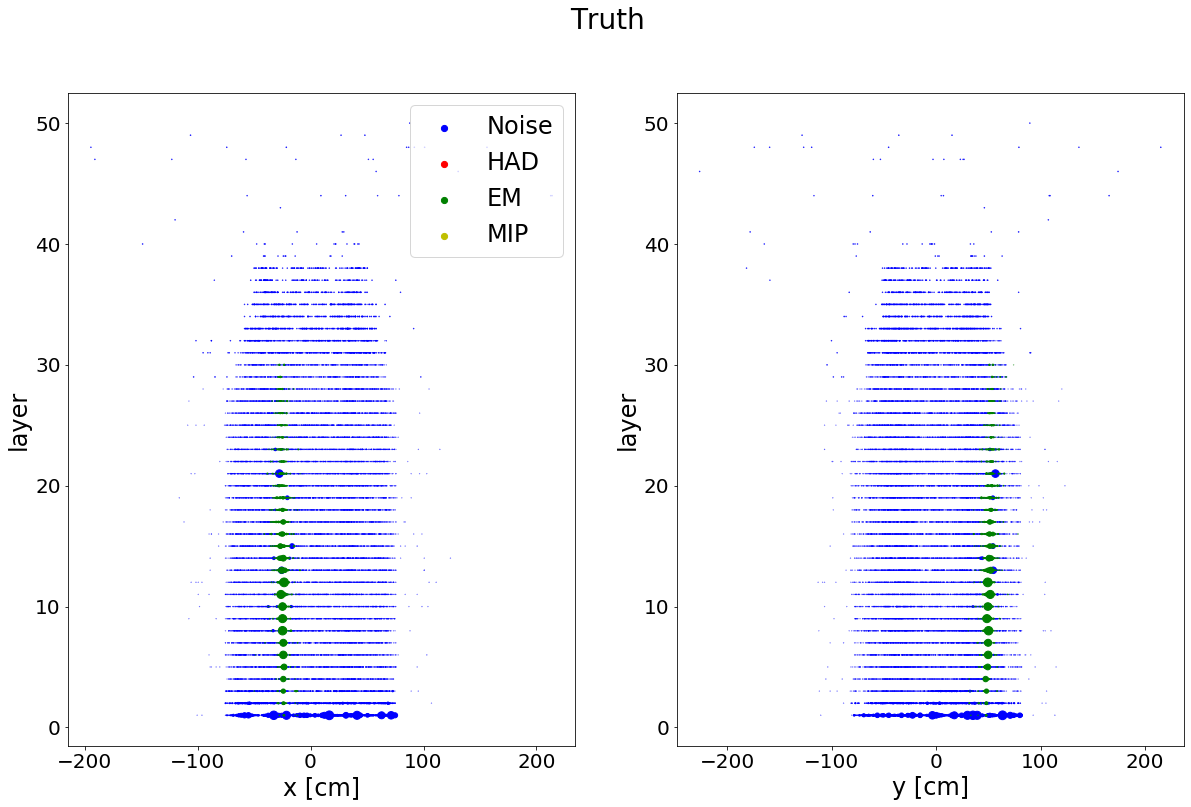

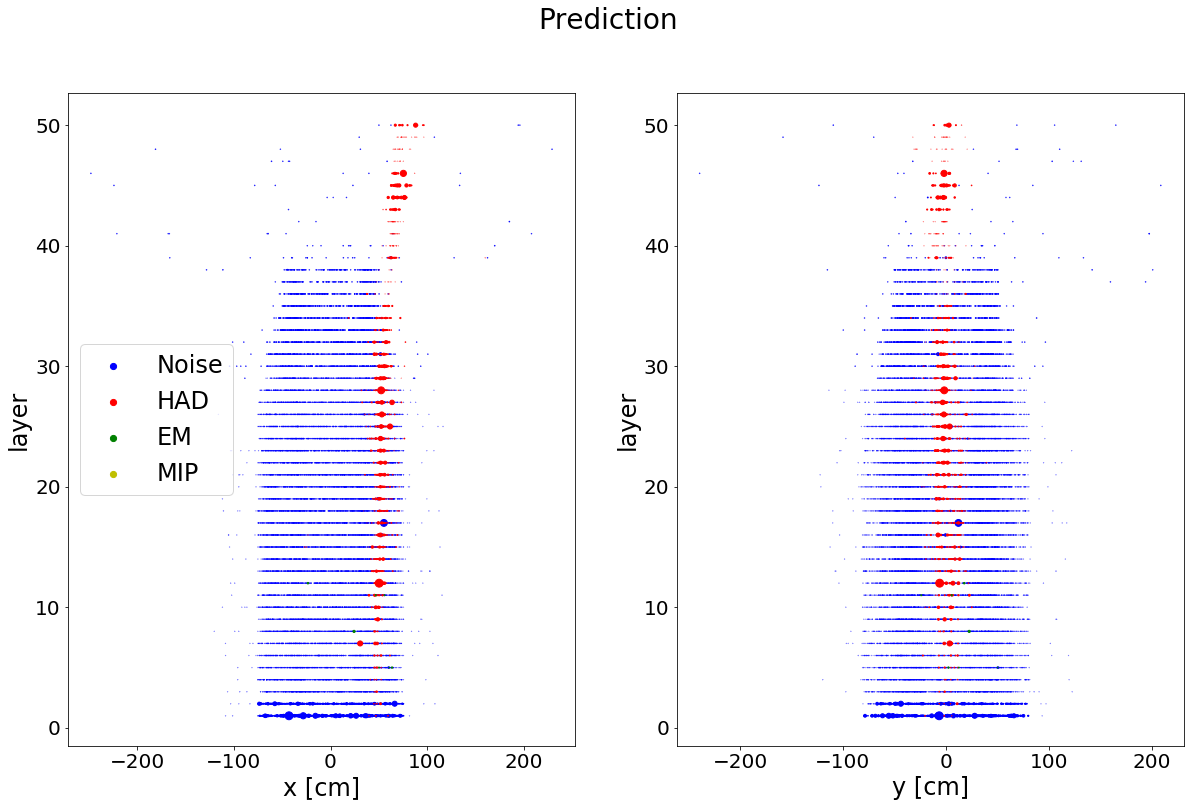

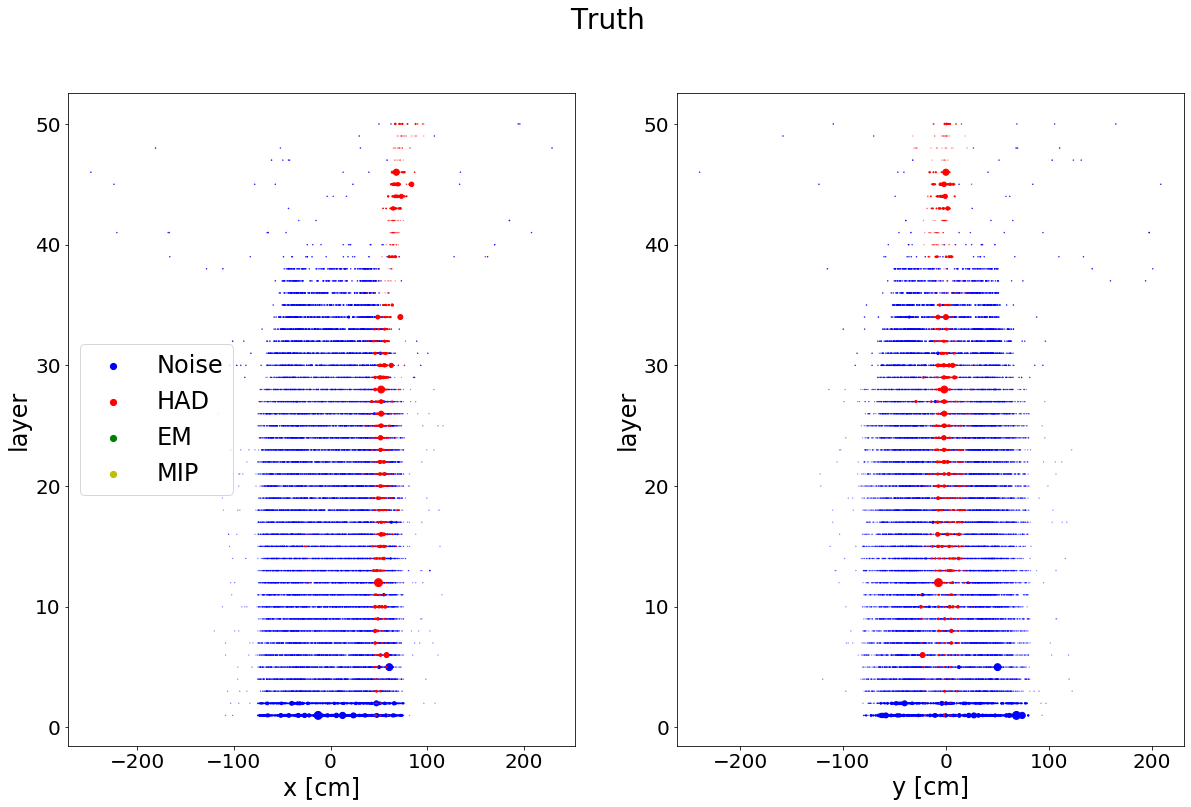

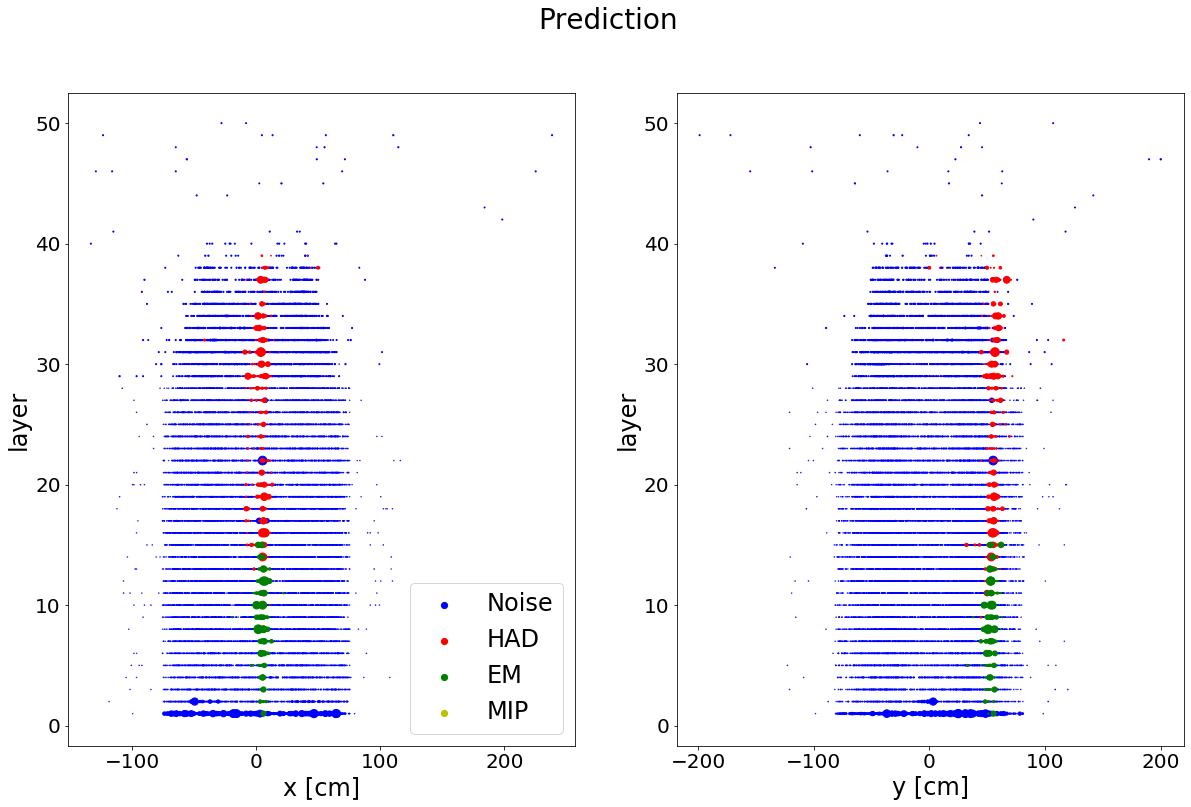

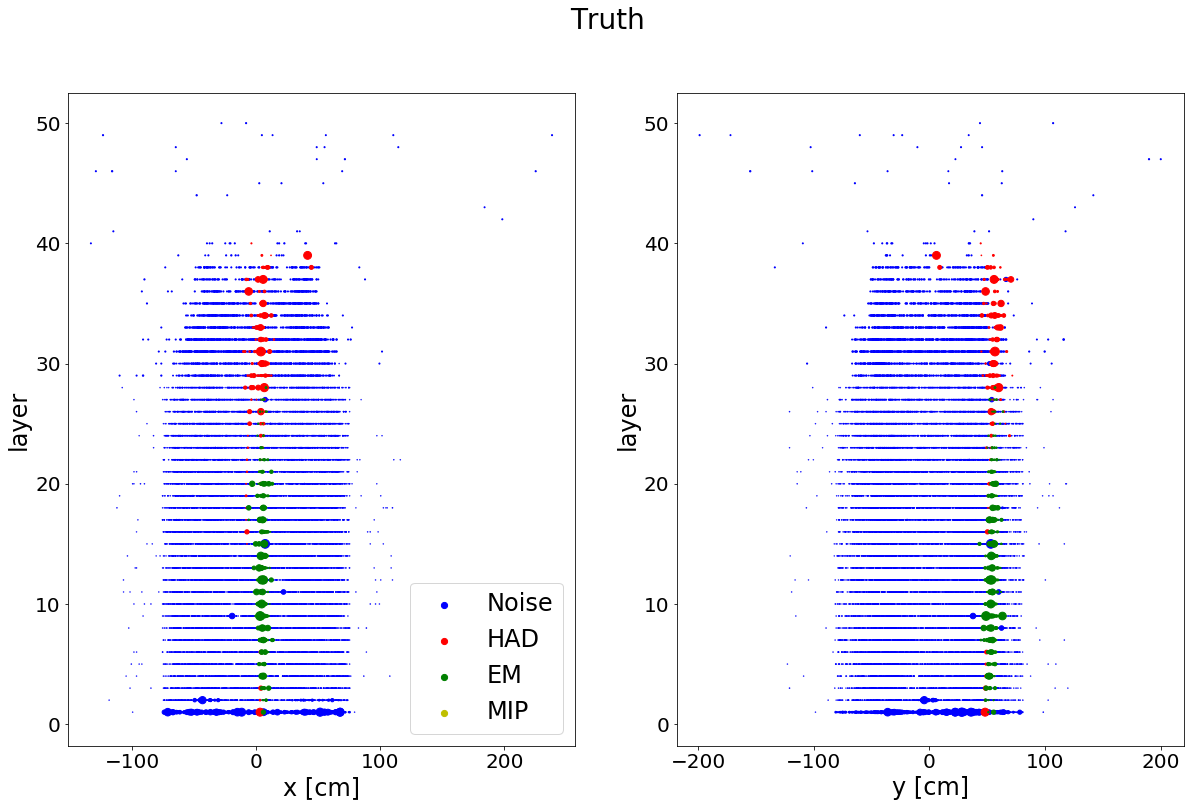

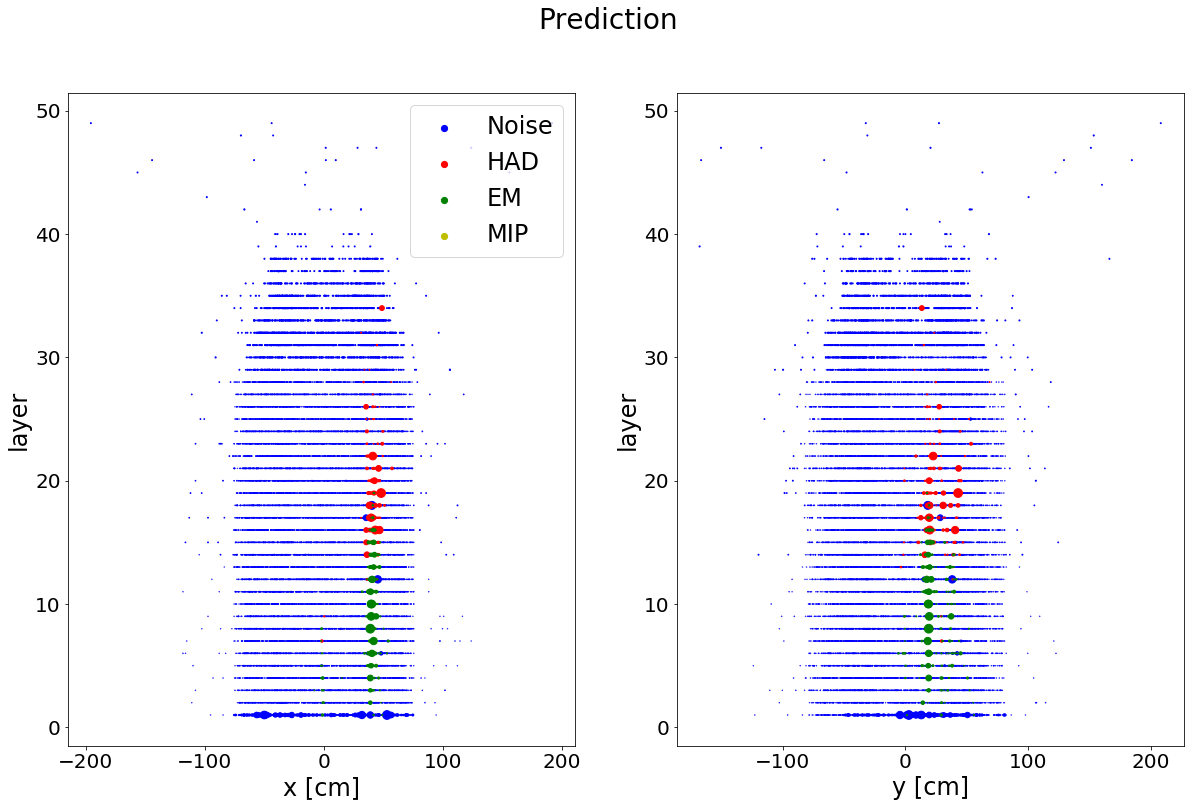

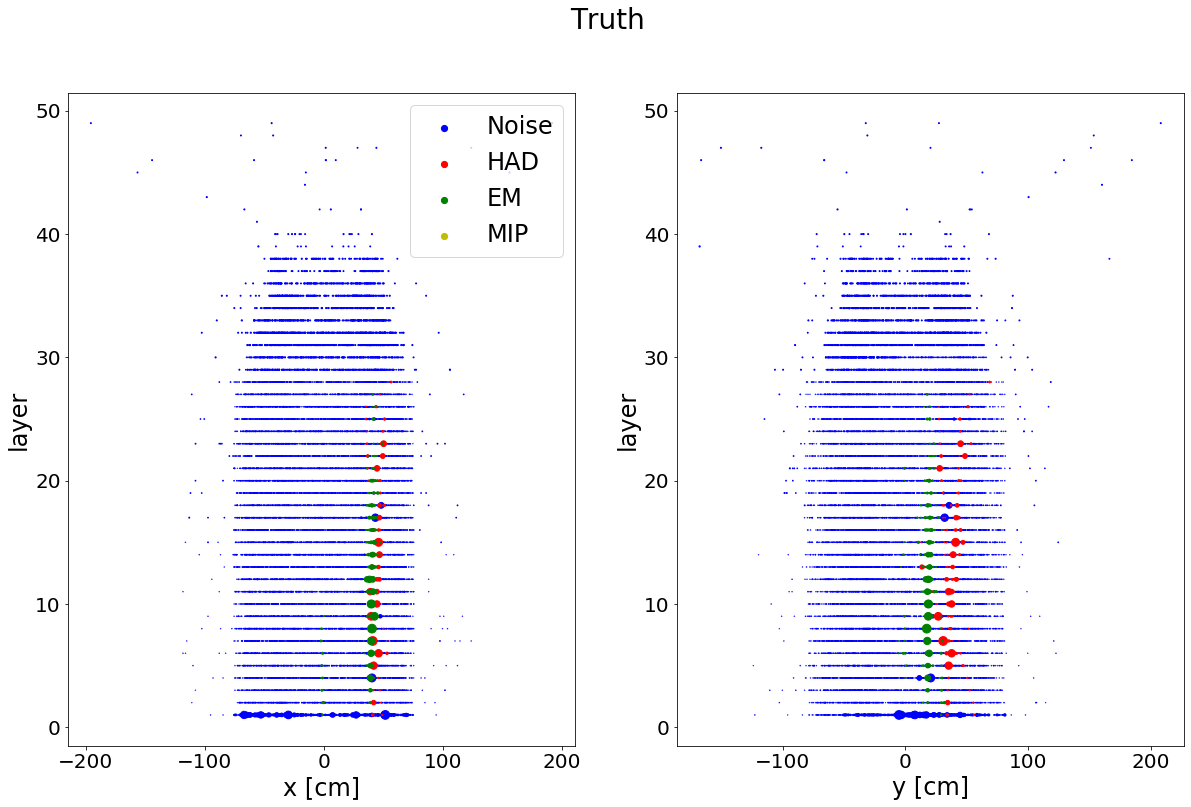

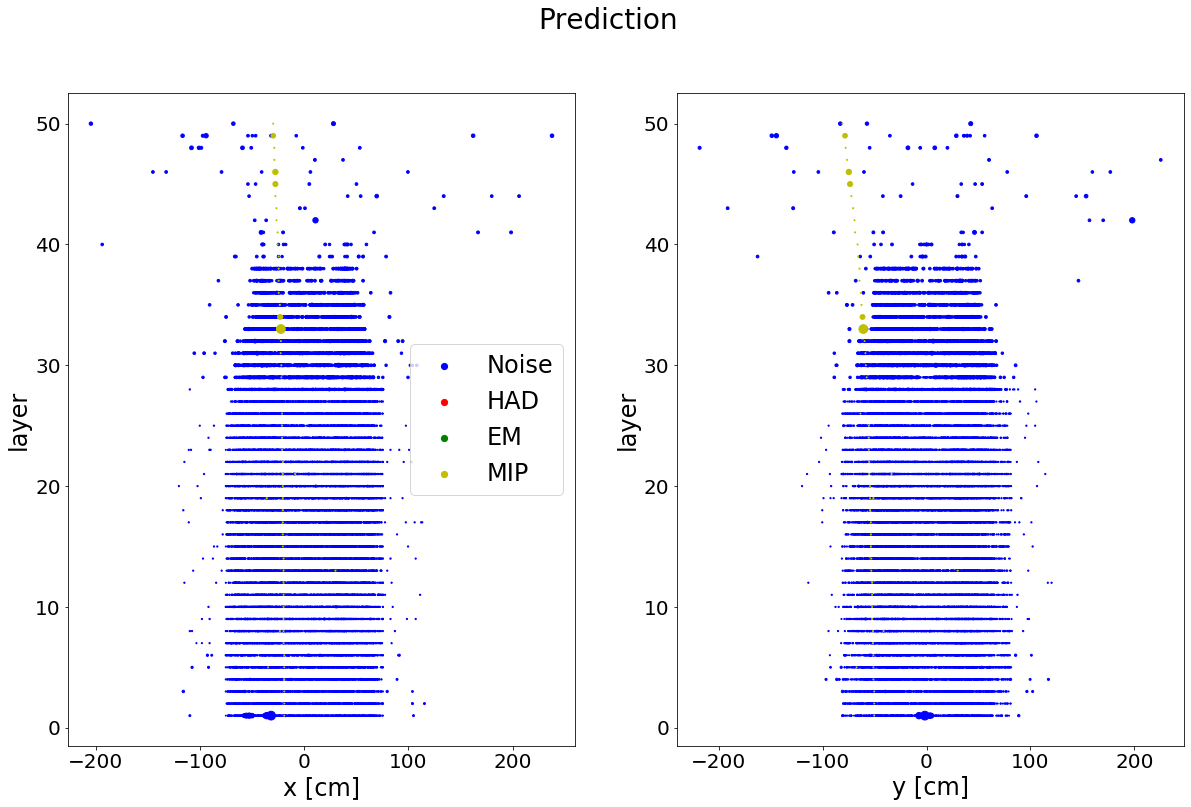

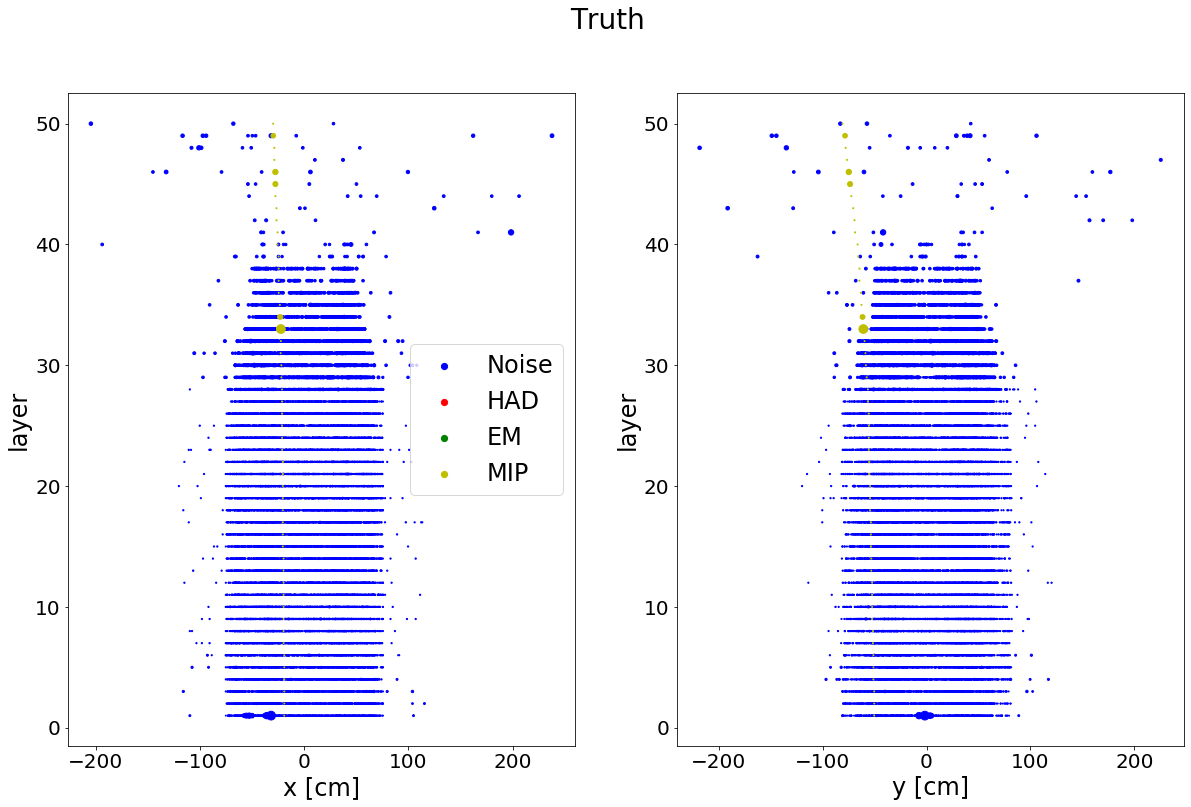

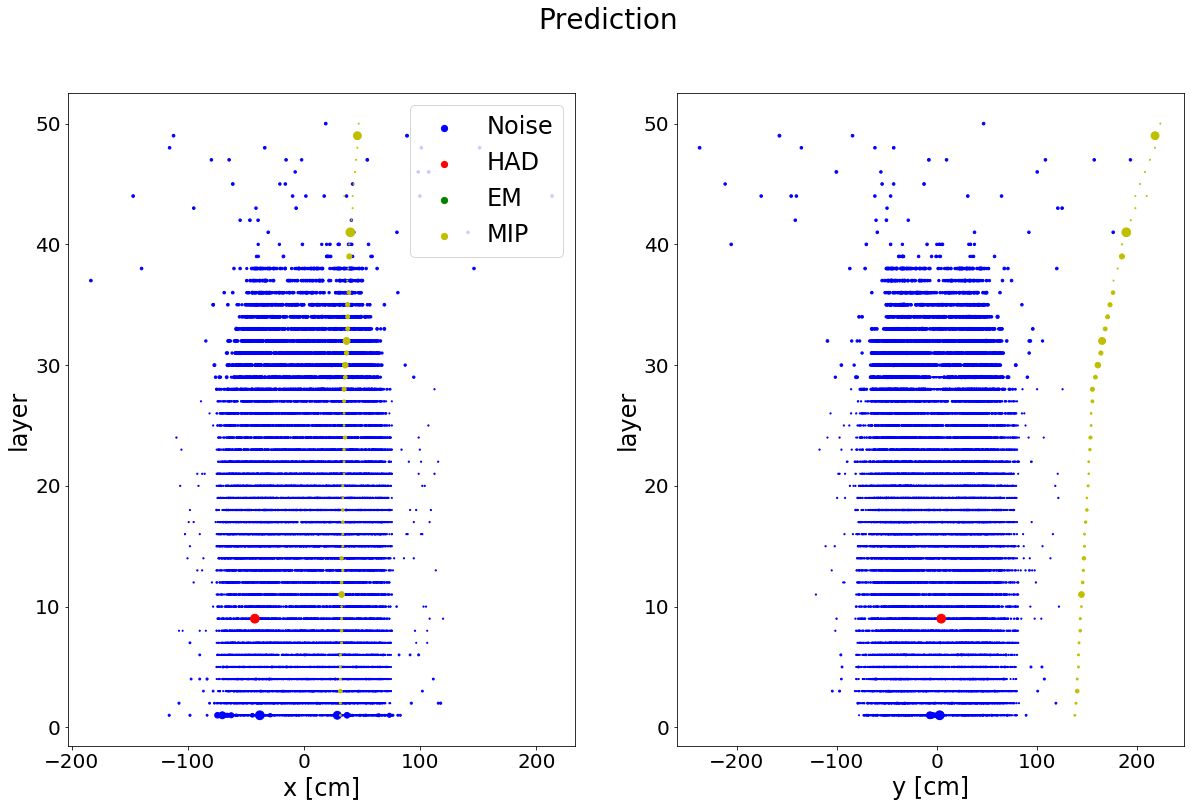

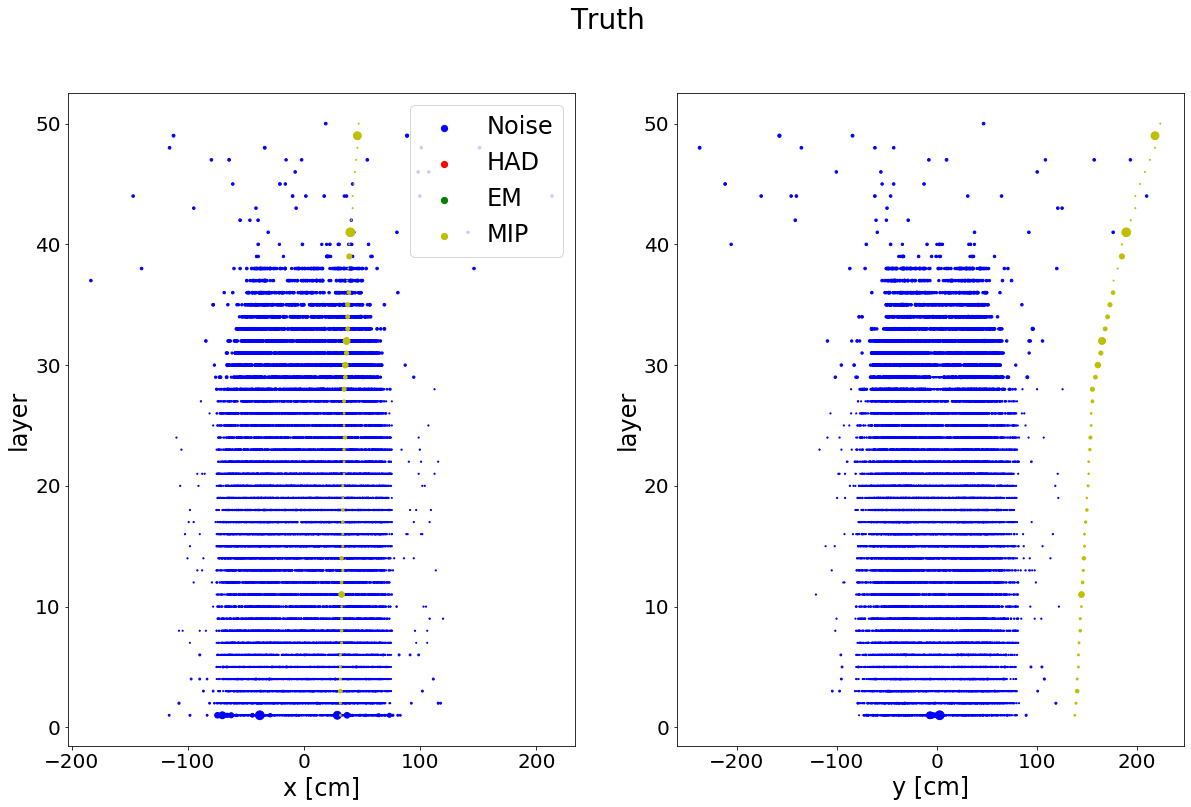

In [18]:
i = 0

for event in EventFactory(valid_loader):
    plot = PlotEventDisplay(event)
    plot.plot_prediction()
    plot.plot_truth()
    
    i += 1
    if i == 10: break

In [78]:
if not osp.isdir('eventdisplays'): os.makedirs('eventdisplays')

backend_ =  matplotlib.get_backend() 
matplotlib.use("Agg")  # Prevent showing stuff

for i_event, event in enumerate(EventFactory(valid_loader, max_events=100)):
    plot = PlotEventDisplay(event)
    plot.plot_prediction('eventdisplays/{0:03d}_pred.png'.format(i_event))
    plot.plot_truth('eventdisplays/{0:03d}_truth.png'.format(i_event))

matplotlib.use(backend_) # Reset backend

In [19]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

class PlotStatistics():
    def __init__(self, loader):
        self.loader = loader
        self.num_classes = 4
        self.n_events = 100
#         self.n_events = None
        
    def events(self):
        return EventFactory(self.loader, self.n_events)
                
    def single_confusion_matrix(self, event):
        conf_mat = confusion_matrix(
            event.target, event.output,
            labels = np.arange(self.num_classes),
            # normalize = 'true'
            )
        # If there are zero events of a category, sklearn puts a zero
        # on the diagonal. That screws up averaging.
        # for i_cat in range(self.num_classes):
        #     if conf_mat[i_cat][i_cat] == 0.0:
        #         conf_mat[i_cat][i_cat] = 1.0
        return conf_mat
    
    def average_confusion_matrix(self):
        total_confusion_matrix = np.zeros((self.num_classes, self.num_classes))
        for event in self.events():
            total_confusion_matrix = np.add(
                total_confusion_matrix,
                self.single_confusion_matrix(event)
                )
        sums = total_confusion_matrix.sum(axis=0)
        return total_confusion_matrix / sums
    
    def _energy_collection_perevent(self, event, i_cat):
        pred_energy = event.X[event.output == i_cat][:,4].sum()
        true_energy = event.X[event.target == i_cat][:,4].sum()
        return pred_energy/true_energy if true_energy > 0. else -1
    
    def get_energy_collection(self):
        energy_collection_per_cat = [ [] for i_cat in range(self.num_classes) ]
        for event in self.events():
            for i_cat in range(self.num_classes):
                energy_collection = self._energy_collection_perevent(event, i_cat)
                if energy_collection != -1:
                    energy_collection_per_cat[i_cat].append(energy_collection)
        return energy_collection_per_cat

    def plot_energy_collection_hist(self, energy_collection_per_cat=None, savefig=None):
        fig, axs = plt.subplots(2, 2, figsize=(12,12))
        color_cycler = cycler.cycler(color=['b', 'r', 'g', 'y', 'm', 'c'])()
        labels = [ 'Noise', 'HAD', 'EM', 'MIP' ]
        
        if energy_collection_per_cat is None:
            energy_collection_per_cat = self.get_energy_collection()
        
        for i_cat, ax in zip(range(self.num_classes), axs.ravel()):
            ax.hist(
                energy_collection_per_cat[i_cat],
                bins = np.linspace(0.5, 1.5, 50),
                histtype = u'step', label = labels[i_cat],
                **next(color_cycler)
                )
            ax.legend(fontsize=14)
            ax.set_ylabel('Count', fontsize=14)
            ax.set_xlabel('E_pred / E_true', fontsize=14)
            
        if savefig: fig.savefig(savefig, bbox_inches='tight')

plot = PlotStatistics(valid_loader)

In [20]:
conf_mat = plot.average_confusion_matrix()

In [21]:
conf_mat

array([[9.98050820e-01, 3.64133023e-02, 2.51288149e-02, 2.44604317e-02],
       [9.64287867e-04, 8.20790417e-01, 1.63674197e-01, 3.02158273e-02],
       [9.06595430e-04, 1.41167331e-01, 8.10978993e-01, 4.31654676e-03],
       [7.82968781e-05, 1.62895020e-03, 2.17994451e-04, 9.41007194e-01]])

In [82]:
# plot.n_events = 10
plot.n_events = None
energy_collection_per_cat = plot.get_energy_collection()

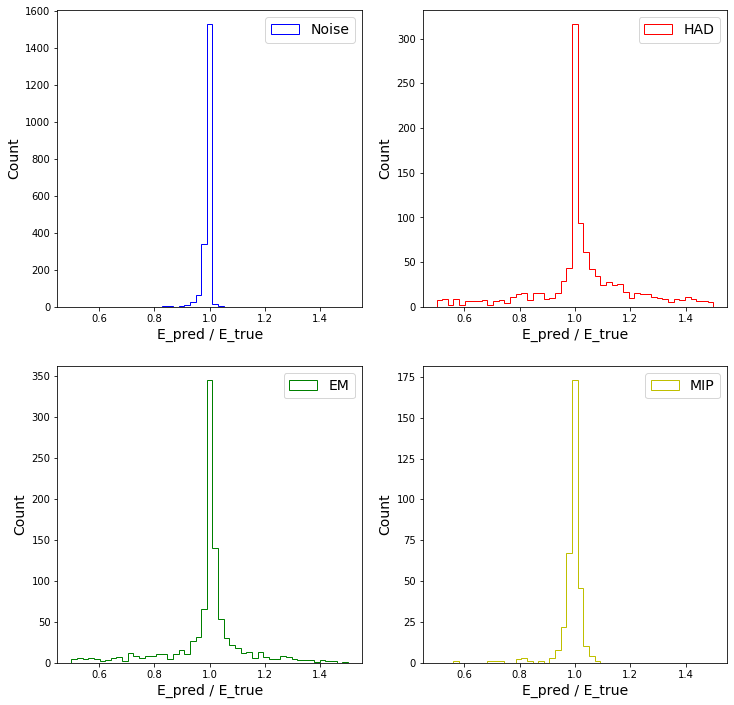

In [83]:
plot.plot_energy_collection_hist(energy_collection_per_cat, savefig='energycollection.pdf')

In [59]:


len(valid_loader.dataset)

2000

# Run stats

In [1]:
run1 = {
    'epoch': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
        ],
    'lr': [
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.002, 0.002, 0.002, 0.002
        ],
    'train_time': [
        6324.177651166916, 4253.762487649918, 4218.124219417572, 4221.684273719788, 4183.307936906815, 4134.225873947144, 4061.6644065380096, 4047.90536570549, 4061.4135117530823, 4183.588454723358, 4131.583730697632, 4088.7306637763977, 4093.697160959244, 4085.569967508316, 4125.02201962471
        ],
    'train_loss': [
        0.10377288740255608, 0.057448003104209416, 0.03804767565054135, 0.030795274627362233, 0.02854671766355068, 0.027766726381344142, 0.0266493256749834, 0.025907407293525465, 0.02524809802173536, 0.02536988424669403, 0.02481759059849992, 0.021999413916200295, 0.021448805694961378, 0.021116232348740736, 0.0208053860092015
        ],
     'valid_time': [
        410.6458647251129, 309.39966893196106, 312.68042373657227, 317.21641731262207, 309.434232711792, 307.60900807380676, 299.0926079750061, 309.525661945343, 296.1599464416504, 300.8047549724579, 298.83772563934326, 286.12596893310547, 299.20038771629333, 295.50660276412964, 297.86000752449036
        ],
     'valid_loss': [
        0.07089184696495067, 0.05946131413634066, 0.045129214793045776, 0.046677020349552546, 0.04286726180333858, 0.04810577621738054, 0.05487118978139779, 0.0587094611109701, 0.04716922001552939, 0.044802185981838646, 0.043591331966815916, 0.04169359848304316, 0.04218300868499455, 0.04274640398865995, 0.04325389367103889
        ],
     'valid_acc': [
        0.9741369388711315, 0.9783958444232737, 0.9844605355593323, 0.9842700274894178, 0.9857962292765973, 0.9842040682156951, 0.9840435304675466, 0.9814934245728191, 0.9831963284292307, 0.9843320316633011, 0.984448694825651, 0.9853877730962661, 0.9852732225959423, 0.9850609737598287, 0.9845620170340992
        ]
    }

run2 = {
    'epoch': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
        ],
    'lr': [
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01
        ],
    'train_time': [
        6393.711959600449, 4178.148412466049, 4157.117978096008, 4157.211435079575, 4125.193572998047, 4118.75168967247, 4127.9372181892395, 4121.673336267471, 4117.5985786914825, 4105.28152012825, 4115.9033353328705, 4131.489298343658, 4111.980840206146, 4104.899773836136, 4055.4143097400665
        ],
    'train_loss': [
        0.023781591811145406, 0.023839383520685545, 0.023557746249838373, 0.02358903770503332, 0.023331180006561567, 0.023001115460672565, 0.022996737414070198, 0.022878607296433415, 0.022649724025650925, 0.022540978932822496, 0.021988861416050724, 0.02180476271676497, 0.021608998738863648, 0.02175516043216362, 0.021404460783450503
        ],
    'valid_time': [
        392.2057523727417, 304.6115503311157, 304.1537148952484, 267.91484928131104, 299.1613919734955, 301.03170013427734, 315.80564403533936, 296.16405749320984, 299.8784658908844, 298.3083529472351, 306.57769656181335, 296.79882192611694, 295.6033601760864, 289.10363030433655, 284.42072653770447
        ],
    'valid_loss': [
        0.041763428910575384, 0.04193023364092005, 0.04622436405170447, 0.042746262200575987, 0.049297176471794955, 0.04292126015310714, 0.04071941465521013, 0.03885517228545359, 0.04151313309676243, 0.04711069894037064, 0.03998220038605632, 0.0434412999295555, 0.03813596879226088, 0.039399069138396615, 0.038342497432137405
        ],
    'valid_acc': [
        0.9835484551441441, 0.9847653484711955, 0.983592206900755, 0.9836144881153794, 0.9824468247267044, 0.9842502765560572, 0.9853446846172681, 0.9850497226062477, 0.984614145741302, 0.9831287723760694, 0.9837094105115303, 0.9829146319704674, 0.9862315113514928, 0.9853260145807581, 0.9853664745151423
        ]
    }

run3 = {
    'epoch': [
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
        ],
    'lr': [
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 4e-05, 4e-05
        ],
    'train_time': [
        6579.7062702178955, 4121.941504478455, 4052.8352406024933, 4053.7479207515717, 4111.890422344208, 4219.363276958466, 4201.746541023254, 4158.108087301254, 4161.344284534454, 4121.543572187424, 4130.514667272568, 4112.220765113831, 4131.285081863403, 4149.606661319733, 4146.7831518650055
        ],
    'train_loss': [
        0.01942829377591437, 0.0186074296199682, 0.018151123122650718, 0.0177781273633979, 0.01747247215665894, 0.01718860979458711, 0.01693912215463733, 0.01669192689661479, 0.01655355881554115, 0.016465987390262598, 0.016394486810130005, 0.01632587990100106, 0.016262892289672877, 0.01623054000479396, 0.016189497770941797
        ],
    'valid_time': [
        368.45184206962585, 295.69405150413513, 294.82334327697754, 295.6670708656311, 310.4765841960907, 304.4638922214508, 298.02760124206543, 293.3672151565552, 298.9092390537262, 290.416663646698, 297.1592609882355, 305.22506046295166, 292.5322005748749, 293.6967179775238, 307.029248714447
        ],
    'valid_loss': [
        0.03701958781151552, 0.03710386449380894, 0.038417042425462566, 0.03940062614059843, 0.04022842611254419, 0.041361153355147506, 0.04218753294138514, 0.039963547263607554, 0.04032462160935256, 0.04062007844858772, 0.041095737234394164, 0.041352529618501194, 0.04165194633220199, 0.04121568229288278, 0.04120165970875905
        ],
    'valid_acc': [
        0.9862051767736787, 0.9861718409321734, 0.985806989113428, 0.9856540913407462, 0.9855609622507339, 0.9853078604268358, 0.9850573625817143, 0.9857811212865266, 0.9857374186615908, 0.9856956321719809, 0.9855818677784575, 0.9855304023488675, 0.9854670961855961, 0.9855438398619871, 0.9855580389160697
        ]
    }

In [9]:
runs = {key : run1[key] + run2[key] + run3[key] for key in run1.keys()}
runs['epoch'] = list(range(len(runs['epoch'])))
runs

{'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44],
 'lr': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.002,
  0.002,
  0.002,
  0.002,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  0.0002,
  4e-05,
  4e-05],
 'train_time': [6324.177651166916,
  4253.762487649918,
  4218.124219417572,
  4221.684273719788,
  4183.307936906815,
  4134.225873947144,
  4061.6644065380096,
  4047.90536570549,
  4061.4135117530823,
  4183.588454723358,
  4131.583730697632,
  4088.7306637763977,
  4093.697160959244,
  4085.569967508316,
  4125.02201962471,
  6393.7

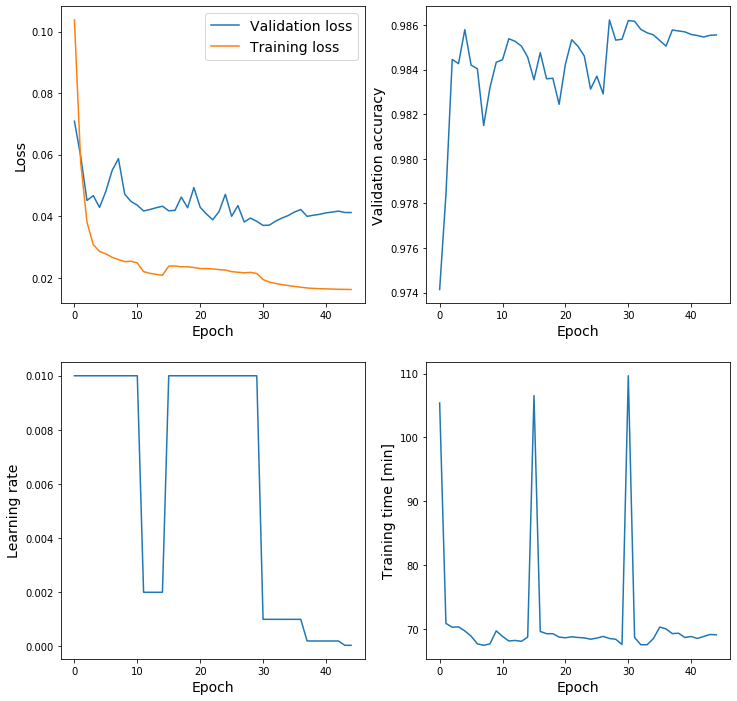

In [24]:
def plot_valid_loss():
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    
    axs[0,0].plot(runs['epoch'], runs['valid_loss'], label='Validation loss')
    axs[0,0].plot(runs['epoch'], runs['train_loss'], label='Training loss')
    axs[0,0].set_xlabel('Epoch', fontsize=14)
    axs[0,0].set_ylabel('Loss', fontsize=14)
    axs[0,0].legend(fontsize=14)

    axs[0,1].plot(runs['epoch'], runs['valid_acc'])
    axs[0,1].set_xlabel('Epoch', fontsize=14)
    axs[0,1].set_ylabel('Validation accuracy', fontsize=14)

    axs[1,0].plot(runs['epoch'], runs['lr'])
    axs[1,0].set_xlabel('Epoch', fontsize=14)
    axs[1,0].set_ylabel('Learning rate', fontsize=14)

    axs[1,1].plot(runs['epoch'], np.array(runs['train_time']) / 60.)
    axs[1,1].set_xlabel('Epoch', fontsize=14)
    axs[1,1].set_ylabel('Training time [min]', fontsize=14)

    

plot_valid_loss()

In [54]:
conf = np.array([[9.98365305e-01, 2.67563432e-02, 2.75065662e-02, 1.63573957e-02],
       [8.55842280e-04, 8.00371637e-01, 1.48721943e-01, 6.79502306e-02],
       [7.20119774e-04, 1.71500373e-01, 8.23290239e-01, 8.90271372e-03],
       [5.87332643e-05, 1.37164677e-03, 4.81252115e-04, 9.06789660e-01]])

labels = ['Noise', 'HAD', 'EM', 'MIP']
print(' '*9, end='')
for l in labels:
    print('{:6s}'.format(l), end='   ')
print()

for i, row in enumerate(conf):
    print('{:6s}'.format(labels[i]), end='   ')
    for e in row:
        print('{0:.4f}'.format(e), end='   ')
    print()


         Noise    HAD      EM       MIP      
Noise    0.9984   0.0268   0.0275   0.0164   
HAD      0.0009   0.8004   0.1487   0.0680   
EM       0.0007   0.1715   0.8233   0.0089   
MIP      0.0001   0.0014   0.0005   0.9068   
